# Update the image WCS and coordinates from file using Gaia

This notebook shows how to use <a href="https://docs.astropy.org/en/stable/index.html">astropy</a> and <a href="https://astroquery.readthedocs.io/en/latest/">astroquery</a> to update an image WCS using Gaia DR3.<br>
The updated WCS is used to convert from pixel X,Y to celestial RA,DEC coordinates.

In [1]:
# Import modules
import numpy as np
import matplotlib
from matplotlib import pyplot as plt

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 12
for axticks in ['xtick','ytick']:
    plt.rcParams['{:}.direction'.format(axticks)] = 'in'
    plt.rcParams['{:}.minor.visible'.format(axticks)] = True

from astropy.io import fits
from astropy import wcs as wcs_apy
from astropy.wcs import WCS
from astropy.table import Table

import astropy.units as u
from astropy.coordinates.sky_coordinate import SkyCoord
from astropy.units import Quantity

# Suppress warnings. Comment this out if you wish to see the warning messages
import warnings
warnings.filterwarnings('ignore')

from astroquery.gaia import Gaia

Created TAP+ (v1.2.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443
Created TAP+ (v1.2.1) - Connection:
	Host: geadata.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443


## 1. Read in the input image and coordinates

In [2]:
in_image = '../reduction/WFC3_U12591_F606W_adrz_drc_sci.fits.gz'
in_coords = '../phot/WFC3_U12591_F814W_adrz_drc_sci_ePSFs.dat'


local_cat = Table.read(in_coords, format ='ascii')

with fits.open(in_image) as hdu:
    if len(hdu) >= 3:
        ext_nr = 1
    else:
        ext_nr = 0

    wcs = WCS(hdu[ext_nr].header)
    data = hdu[ext_nr].data
    data_hdr = fits.getheader(in_image)

## 2. Convert from pixel to RA,DEC using the image WCS

In [3]:
local_cat['RA'],local_cat['DEC'] = wcs.all_pix2world(local_cat['xcentroid'],local_cat['ycentroid'],0)

# Save the table
local_cat.write('local_cat.ascii', format='ascii', overwrite=True)


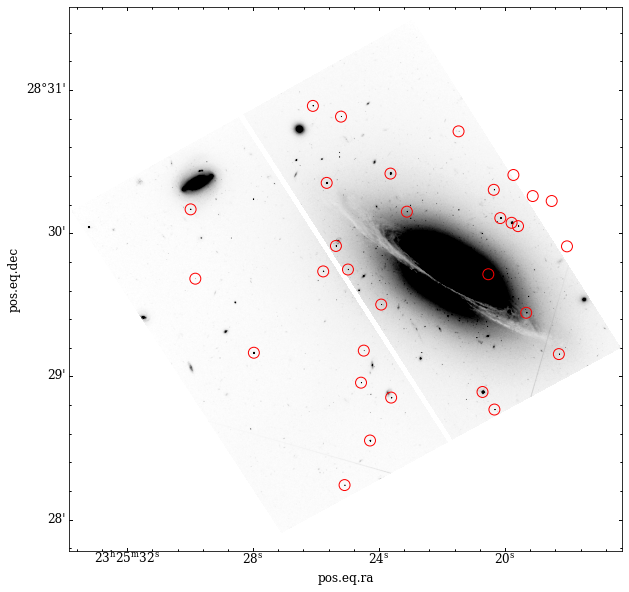

In [4]:
# Visualize

RA_IMG , DEC_IMG = local_cat['RA'],local_cat['DEC']

fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(projection=wcs)

dmin = np.nanpercentile(data,[16.1])*.3
dmax = np.nanpercentile(data,[84.9])*3

ax.imshow(data,origin='lower',cmap='Greys', vmin=dmin, vmax=dmax)
ax.scatter(RA_IMG ,DEC_IMG, marker='o',s=120, transform=ax.get_transform('fk5'),
            facecolor='none', edgecolor='red')

## 3. Query Gaia around the RA,DEC coordinates in the local catalog

In [5]:
# Readin local table with RA,DEC

local_cat = Table.read('local_cat.ascii', format='ascii')

# Save the table in VOT format if not laready
try:
    local_cat.write('local_cat.vot', format='votable') #, overwrite=True)
except:
    pass
upload_resource = 'local_cat.vot'

# Define the RA,DEC coordinate search radius to match between Gaia and local_cat
# Some proper motion quality filtering is applied too.

search_r = 1*u.arcsec
search_r = search_r.to(u.degree).value

# Define the Gaia query. It uploads the local catalog 
adql = "SELECT * \
FROM tap_upload.myVOtable AS myVOtable \
JOIN gaiaedr3.gaia_source AS gaia \
ON 1=CONTAINS(\
        POINT('ICRS',myVOtable.ra,myVOtable.dec),\
        CIRCLE('ICRS',gaia.ra,gaia.dec,{:})\
        );\
WHERE \
AND abs(pmra_error/pmra)<0.10 \
AND abs(pmdec_error/pmdec)<0.10 \
AND pmra IS NOT NULL AND abs(pmra)>0 \
AND pmdec IS NOT NULL AND abs(pmdec)>0;".format(search_r)

job = Gaia.launch_job_async(adql, dump_to_file=False,
                            upload_resource=upload_resource,
                            upload_table_name='myVOtable', verbose=True
                           )

result_tbl = job.get_results()
result_tbl

Launched query: 'SELECT * FROM tap_upload.myVOtable AS myVOtable JOIN gaiaedr3.gaia_source AS gaia ON 1=CONTAINS(        POINT('ICRS',myVOtable.ra,myVOtable.dec),        CIRCLE('ICRS',gaia.ra,gaia.dec,0.0002777777777777778)        );WHERE AND abs(pmra_error/pmra)<0.10 AND abs(pmdec_error/pmdec)<0.10 AND pmra IS NOT NULL AND abs(pmra)>0 AND pmdec IS NOT NULL AND abs(pmdec)>0;'
------>https
host = gea.esac.esa.int:443
context = /tap-server/tap/async
Content-type = multipart/form-data; boundary====1618843953032===
303 303
[('Date', 'Mon, 19 Apr 2021 14:52:33 GMT'), ('Server', 'Apache/2.4.6 (CentOS) OpenSSL/1.0.2k-fips PHP/5.4.16 mod_jk/1.2.43'), ('Cache-Control', 'no-cache, no-store, max-age=0, must-revalidate'), ('Pragma', 'no-cache'), ('Expires', '0'), ('X-XSS-Protection', '1; mode=block'), ('X-Frame-Options', 'SAMEORIGIN'), ('X-Content-Type-Options', 'nosniff'), ('Set-Cookie', 'JSESSIONID=C37BF2D6EA6F42387EB157C08FEE94E6; Path=/tap-server; Secure; HttpOnly'), ('Location', 'https://gea.

id,xcentroid,ycentroid,sharpness,roundness1,roundness2,npix,sky,peak,flux,mag,ra,dec,solution_id,designation,source_id,random_index,ref_epoch,ra_2,ra_error,dec_2,dec_error,parallax,parallax_error,parallax_over_error,pm,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,astrometric_n_obs_al,astrometric_n_obs_ac,astrometric_n_good_obs_al,astrometric_n_bad_obs_al,astrometric_gof_al,astrometric_chi2_al,astrometric_excess_noise,astrometric_excess_noise_sig,astrometric_params_solved,astrometric_primary_flag,nu_eff_used_in_astrometry,pseudocolour,pseudocolour_error,ra_pseudocolour_corr,dec_pseudocolour_corr,parallax_pseudocolour_corr,pmra_pseudocolour_corr,pmdec_pseudocolour_corr,astrometric_matched_transits,visibility_periods_used,astrometric_sigma5d_max,matched_transits,new_matched_transits,matched_transits_removed,ipd_gof_harmonic_amplitude,ipd_gof_harmonic_phase,ipd_frac_multi_peak,ipd_frac_odd_win,ruwe,scan_direction_strength_k1,scan_direction_strength_k2,scan_direction_strength_k3,scan_direction_strength_k4,scan_direction_mean_k1,scan_direction_mean_k2,scan_direction_mean_k3,scan_direction_mean_k4,duplicated_source,phot_g_n_obs,phot_g_mean_flux,phot_g_mean_flux_error,phot_g_mean_flux_over_error,phot_g_mean_mag,phot_bp_n_obs,phot_bp_mean_flux,phot_bp_mean_flux_error,phot_bp_mean_flux_over_error,phot_bp_mean_mag,phot_rp_n_obs,phot_rp_mean_flux,phot_rp_mean_flux_error,phot_rp_mean_flux_over_error,phot_rp_mean_mag,phot_bp_n_contaminated_transits,phot_bp_n_blended_transits,phot_rp_n_contaminated_transits,phot_rp_n_blended_transits,phot_proc_mode,phot_bp_rp_excess_factor,bp_rp,bp_g,g_rp,dr2_radial_velocity,dr2_radial_velocity_error,dr2_rv_nb_transits,dr2_rv_template_teff,dr2_rv_template_logg,dr2_rv_template_fe_h,l,b,ecl_lon,ecl_lat
,,,,,,,,,,,,,,,,,yr,deg,mas,deg,mas,mas,mas,,mas / yr,mas / yr,mas / yr,mas / yr,mas / yr,,,,,,,,,,,,,,,,,mas,,,,1 / um,1 / um,1 / um,,,,,,,,mas,,,,,deg,,,,,,,,deg,deg,deg,deg,,,electron / s,electron / s,,mag,,electron / s,electron / s,,mag,,electron / s,electron / s,,mag,,,,,,,mag,mag,mag,km / s,km / s,,K,log(cm.s**-2),dex,deg,deg,deg,deg
int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,int64,object,int64,int64,float64,float64,float32,float64,float32,float64,float32,float32,float32,float64,float32,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,int16,int16,float32,float32,float32,float32,int16,bool,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,float32,int16,int16,int16,float32,float32,int16,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,bool,int16,float64,float32,float32,float32,int16,float64,float32,float32,float32,int16,float64,float32,float32,float32,int16,int16,int16,int16,int16,float32,float32,float32,float32,float32,float32,int16,float32,float32,float32,float64,float64,float64,float64
1350,5247.980870563731,2015.8877815975184,0.808005299958346,0.04952503479705133,0.015243287515717505,1155,0.0,155967.81468963623,13908.922045220646,-10.358233682644931,351.33631108201,28.48153784413809,1636042515805110273,Gaia EDR3 2869112856096304768,2869112856096304768,793667561,2016.0,351.336356535684,0.095033884,28.48152098792494,0.07587714,0.7773978404168316,0.12965995,5.9956665,1.5544399,1.5413782316421092,0.11770619,-0.2010887710057861,0.09817026,0.25456515,0.23069032,-0.3414211,-0.168494,-0.116526164,-0.1331613,0.14004251,-0.14388749,-0.28694683,0.22554025,382,0,381,1,0.32406837,401.608,0.0,0.0,31,False,1.3853682,--,--,--,--,--,--,--,44,21,0.17629044,52,18,0,0.03178665,69.96019,0,0,1.0109509,0.21471302,0.2924201,0.020413423,0.35908917,173.76906,-27.926662,-51.95426,23.857483,False,416,1235.4920921050802,1.4459847,854.42957,17.957767,44,443.5230179186932,9.342903,47.47165,18.721252,42,1161.8526671754928,8

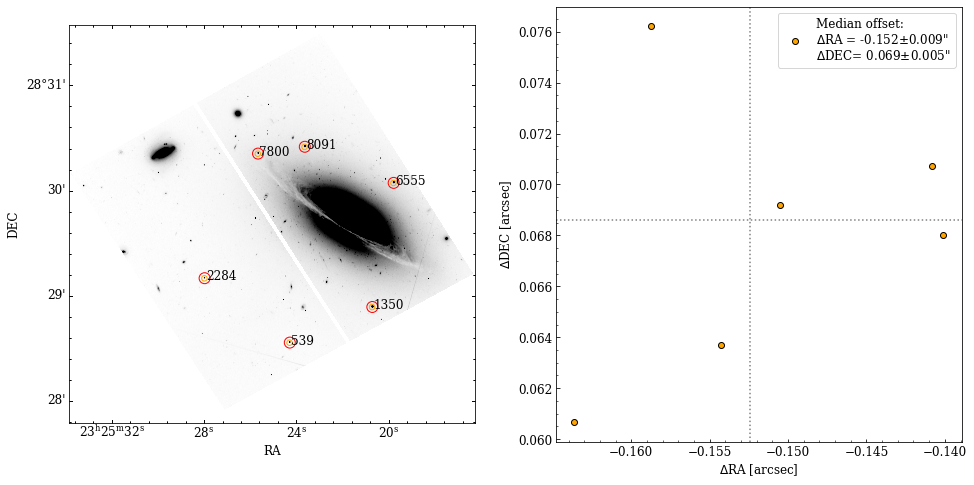

In [6]:
# Visualize

RA_IMG , DEC_IMG = result_tbl['ra'],result_tbl['dec']
RA_Gaia , DEC_Gaia = result_tbl['ra_2'],result_tbl['dec_2']

dRA = np.median((result_tbl['ra']-result_tbl['ra_2'])*3600.)
dDec = np.median((result_tbl['dec']-result_tbl['dec_2'])*3600.)
sdtRA = np.std((result_tbl['ra']-result_tbl['ra_2'])*3600.)
stdDec = np.std((result_tbl['dec']-result_tbl['dec_2'])*3600.)


fig = plt.figure(figsize=(16,8))

ax1 = fig.add_subplot(121, adjustable='box', projection=wcs)
ax2 = fig.add_subplot(122, adjustable='box')

dmin = np.nanpercentile(data,[16.1])*.3
dmax = np.nanpercentile(data,[84.9])*3

ax1.imshow(data,origin='lower',cmap='Greys', vmin=dmin, vmax=dmax)
ax1.scatter(RA_IMG ,DEC_IMG, marker='o',s=120, transform=ax1.get_transform('fk5'),
            facecolor='none', edgecolor='red')
ax1.scatter(RA_Gaia , DEC_Gaia, marker='o',s=30, transform=ax1.get_transform('fk5'),
            facecolor='none', edgecolor='orange')
ax1.set_xlabel('RA')
ax1.set_ylabel('DEC')

x_txt,y_txt = result_tbl['ra']-.75/3600,result_tbl['dec']-1.01/3600

for x,y,i,j in zip(x_txt,y_txt,result_tbl['id'],range(len(result_tbl))):
    ax1.text(x-.1/3600.,y,i,transform=ax1.get_transform('fk5'))
    
ax2.plot((result_tbl['ra']-result_tbl['ra_2'])*3600.,
         (result_tbl['dec']-result_tbl['dec_2'])*3600., 'o', color='orange',
         markeredgecolor='black',
         label='Median offset:\n$\Delta$RA = {:.3f}$\pm${:.3f}\"\n$\Delta$DEC= {:.3f}$\pm${:.3f}\"'.format(dRA,sdtRA,dDec,stdDec))
ax2.set_xlabel('$\Delta$RA [arcsec]',fontsize=12)
ax2.set_ylabel('$\Delta$DEC [arcsec]',fontsize=12)
ax2.legend(fontsize=12)

ax2.axhline(dDec,ls=':',color='grey')
ax2.axvline(dRA,ls=':',color='grey')

## 4. Create the new WCS from the matched data

In [7]:
# Create a SkyCoord object needed as input for fitting with wcs_apy.utils.fit_wcs_from_points

# If result_tbl is not a QTabke with ra,dec unitsin deg
#ref_coos = SkyCoord(ra=result_tbl['ra_2']*u.degree, dec=result_tbl['dec_2']*u.degree)
ref_coos = SkyCoord(ra=result_tbl['ra_2'], dec=result_tbl['dec_2'])

# Get the pixel values corresponding to those RA,DEC
x_pix, y_pix = result_tbl['xcentroid'],result_tbl['ycentroid']

In [8]:
# Update the WCS

updated_wcs = wcs_apy.utils.fit_wcs_from_points((x_pix, y_pix), ref_coos,
                                                proj_point='center',
                                                projection=wcs, sip_degree=None)


In [9]:
# Have a look at the old and new 
wcs,updated_wcs

(WCS Keywords
 
 Number of WCS axes: 2
 CTYPE : 'RA---TAN'  'DEC--TAN'  
 CRVAL : 351.354424955284  28.49467968181878  
 CRPIX : 3512.082673323113  3450.411896762341  
 CD1_1 CD1_2  : -9.1666666666666e-06  1.41798532695857e-22  
 CD2_1 CD2_2  : -3.4925568392014e-23  9.16666666666666e-06  
 NAXIS : 7022  6900,
 WCS Keywords
 
 Number of WCS axes: 2
 CTYPE : 'RA---TAN'  'DEC--TAN'  
 CRVAL : 351.3495609899052  28.49140166165781  
 CRPIX : 3982.4432804110725  3094.880757707858  
 CD1_1 CD1_2  : -9.16537555472438e-06  1.5596004258229308e-10  
 CD2_1 CD2_2  : 4.405305257897276e-10  9.166172563149566e-06  
 NAXIS : 3272.4002054488155  3389.2104527102424)

In [ ]:
# OPTIONAL
# Copy, the old header
new_data_hdr = data_hdr.copy()

# Convert the new WCS object to a header object
tmp_hdr = updated_wcs.to_header()

# Update the new copy of the old header 
new_data_hdr.update(tmp_hdr)

# Write to a new fits file
fits.writeto("New_image_w_updated_WCS.fits", data=data.data, header=new_data_hdr) #, overwrite=True)

## 5. Use the updated WCS to update the RA DEC

In [10]:
local_cat['RA_Gaia'],local_cat['DEC_Gaia'] = updated_wcs.all_pix2world(local_cat['xcentroid'],local_cat['ycentroid'],0)


In [11]:
# Convert other coordinates from the same image X,Y [pix] to RA,DEC

sup_local = '../phot/selCCs_wSSP.dat'

tab = Table.read(sup_local, format ='ascii')

tab['RA_Gaia'],tab['DEC_Gaia'] = updated_wcs.all_pix2world(tab['x606'],tab['y606'],0)

tab.meta['comments'] = 'RADEC coordinates added with '

tab.write('../phot/selCCs_wSSP_RADEC.ecsv', format = 'ascii.ecsv') #, comment = '#') #, overwrite = True